## Medical insurance data set
* https://www.kaggle.com/datasets/teertha/ushealthinsurancedataset
    * 1400 data points

## Results
* DNN: R² of 0.83
* RandomForest: R² of 0.87
* LinearRegression: bad idea, non-linear data R² of 0.78
* Same with Ridge Regressor

### Next steps
* Data augmentation
* cross validation
* privacy attacks
* differential privacy


In [2]:
import pandas as pd

validation_split_size = 0.2
dataset = pd.read_csv('data/med-insurance/insurance.csv')

In [3]:
# categorical data columns
dataset['sex'] = dataset['sex'].astype('category').cat.codes
dataset['region'] = dataset['region'].astype('category').cat.codes
dataset['smoker'] = dataset['smoker'].astype('category').cat.codes
dataset

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1,10600.54830
1334,18,0,31.920,0,0,0,2205.98080
1335,18,0,36.850,0,0,2,1629.83350
1336,21,0,25.800,0,0,3,2007.94500


In [4]:
dataset['region'].value_counts()

2    364
3    325
1    325
0    324
Name: region, dtype: int64

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# von 0-1 skalieren
dataset[['age', 'bmi', 'children']] = scaler.fit_transform(dataset[['age', 'bmi', 'children']])
# one hot encoding
dataset[['region0', 'region1', 'region2', 'region3']] = pd.get_dummies(dataset['region'])
dataset

,age,sex,bmi,children,smoker,region,charges,region0,region1,region2,region3
0,0.021739,0,0.321227,0.0,1,3,16884.92400,0,0,0,1
1,0.000000,1,0.479150,0.2,0,2,1725.55230,0,0,1,0
2,0.217391,1,0.458434,0.6,0,2,4449.46200,0,0,1,0
3,0.326087,1,0.181464,0.0,0,1,21984.47061,0,1,0,0
4,0.304348,1,0.347592,0.0,0,1,3866.85520,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1333,0.695652,1,0.403820,0.6,0,1,10600.54830,0,1,0,0
1334,0.000000,0,0.429379,0.0,0,0,2205.98080,1,0,0,0
1335,0.000000,0,0.562012,0.0,0,2,1629.83350,0,0,1,0
1336,0.065217,0,0.264730,0.0,0,3,2007.94500,0,0,0,1


In [6]:
training_features = ['age', 'sex', 'bmi', 'children', 'smoker', 'region0', 'region1', 'region2', 'region3']
target_variable = 'charges'
def get_x(d):
    return d[training_features]

def get_y(d):
    return d[[target_variable]]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset[training_features], dataset[[target_variable]], test_size=0.2, random_state=42, shuffle=True)

In [8]:
# import, plot function
import matplotlib.pyplot as plt

def plot_loss(history, y_min=None, y_max=None):
    plt.plot(history.history['r_square'], label='train R^2')
    plt.plot(history.history['val_r_square'], label='test R^2')
    if y_min is not None and y_max is not None:
        plt.ylim([y_min, y_max])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    plt.savefig('fig.png')

# DNN

In [8]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow_addons.metrics import RSquare

# DNN: compose and compile
dnn_model = Sequential([
    keras.Input(shape=(9,)),
    Dense(32, activation='relu'),
    keras.layers.Dropout(0.05),
    Dense(16, activation='relu'),
    Dense(1)
])

dnn_model.compile(loss=tf.losses.mae,
                  optimizer=tf.optimizers.SGD(),
                  metrics=["mae", 'mean_squared_error', RSquare()]
                  )

2022-11-15 13:08:15.705718: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 13:08:15.859325: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-15 13:08:15.859356: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-15 13:08:15.888500: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-15 13:08:17.703824: W tensorflow/stream_executor/platform/de

In [9]:
# DNN: train
dnn_history = dnn_model.fit(
    X_train,
    y_train,
    #batch_size=16,
    shuffle=True,
    validation_split=validation_split_size,
    epochs=100)

Epoch 1/100
27/27 [==============================] - 1s 11ms/step - loss: 13518.2100 - mae: 13518.2100 - mean_squared_error: 325458048.0000 - r_square: -1.2804 - val_loss: 12654.4893 - val_mae: 12654.4893 - val_mean_squared_error: 310340064.0000 - val_r_square: -1.0661
Epoch 2/100
27/27 [==============================] - 0s 3ms/step - loss: 13516.6201 - mae: 13516.6201 - mean_squared_error: 325412704.0000 - r_square: -1.2801 - val_loss: 12651.8867 - val_mae: 12651.8867 - val_mean_squared_error: 310269920.0000 - val_r_square: -1.0656
Epoch 3/100
27/27 [==============================] - 0s 3ms/step - loss: 13509.6807 - mae: 13509.6807 - mean_squared_error: 325214080.0000 - r_square: -1.2787 - val_loss: 12633.9863 - val_mae: 12633.9863 - val_mean_squared_error: 309784416.0000 - val_r_square: -1.0624
Epoch 4/100
27/27 [==============================] - 0s 3ms/step - loss: 13095.6904 - mae: 13095.6904 - mean_squared_error: 314357024.0000 - r_square: -1.2027 - val_loss: 8486.7979 - val_mae: 

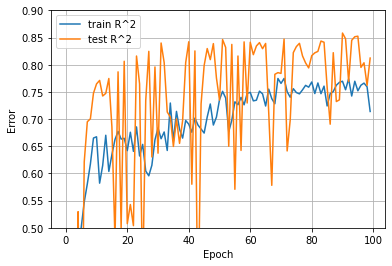

In [10]:
plot_loss(dnn_history, y_min=0.5, y_max=0.9)

In [10]:
# 'age', 'sex', 'bmi', 'children', 'smoker', 'region'
dnn_model.predict([[0.9, 0, 0, 0.1, 0, 0,0,0,1]])

1/1 [==============================] - 0s 104ms/step


array([[11031.147]], dtype=float32)

#### keras tune: DNN Hyper search

In [33]:
from tensorflow import keras
from keras import layers
from tensorflow_addons.metrics import RSquare

In [34]:

def build_model(hp):
    model = keras.Sequential()
    model.add(
        layers.Dense(
            # Define the hyperparameter.
            units=hp.Int("units_0", min_value=8, max_value=64, step=8),
            activation="relu",
        )
    )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(
            rate=hp.Float("dropout_rate", min_value=0.1, max_value=0.3, step=0.05)
        ))
    model.add(
        layers.Dense(
            # Define the hyperparameter.
            units=hp.Int("units_1", min_value=2, max_value=14, step=4),
            activation="relu",
        )
    )
    model.add(layers.Dense(1))
    model.compile(
        optimizer="sgd",
        loss="mae",
        metrics=["mae", 'mean_squared_error', RSquare()],
    )
    return model

In [53]:
import keras_tuner

build_model(keras_tuner.HyperParameters())

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_mae",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="keras_tune_results",
    project_name="insurance-dnn-tuner",
)


In [54]:
tuner.search(X_train, y_train, epochs=100, validation_split=validation_split_size)

Trial 3 Complete [00h 00m 19s]
val_mae: 2133.479736328125

Best val_mae So Far: 2133.479736328125
Total elapsed time: 00h 00m 58s
INFO:tensorflow:Oracle triggered exit


In [60]:
best_hps = tuner.get_best_hyperparameters(5)
best_model = build_model(best_hps[0])
best_model.build(input_shape=(None,9))
#best_model.build(input_shape=(None,9))
best_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                160       
                                                                 
 dense_7 (Dense)             (None, 2)                 34        
                                                                 
 dense_8 (Dense)             (None, 1)                 3         
                                                                 
Total params: 197
Trainable params: 197
Non-trainable params: 0
_________________________________________________________________


In [61]:
history = best_model.fit(
    X_train,
    y_train,
    #batch_size=16,
    shuffle=True,
validation_split=validation_split_size,
epochs=100)

Epoch 1/100
27/27 [==============================] - 1s 9ms/step - loss: 13518.7080 - mae: 13518.7080 - mean_squared_error: 325472576.0000 - r_square: -1.2805 - val_loss: 12655.3496 - val_mae: 12655.3496 - val_mean_squared_error: 310362912.0000 - val_r_square: -1.0663
Epoch 2/100
27/27 [==============================] - 0s 3ms/step - loss: 13518.3398 - mae: 13518.3398 - mean_squared_error: 325462336.0000 - r_square: -1.2805 - val_loss: 12655.0400 - val_mae: 12655.0400 - val_mean_squared_error: 310355168.0000 - val_r_square: -1.0662
Epoch 3/100
27/27 [==============================] - 0s 3ms/step - loss: 13518.0469 - mae: 13518.0469 - mean_squared_error: 325454464.0000 - r_square: -1.2804 - val_loss: 12654.7598 - val_mae: 12654.7598 - val_mean_squared_error: 310348064.0000 - val_r_square: -1.0662
Epoch 4/100
27/27 [==============================] - 0s 3ms/step - loss: 13517.7656 - mae: 13517.7656 - mean_squared_error: 325446880.0000 - r_square: -1.2804 - val_loss: 12654.4785 - val_mae: 

In [69]:
X_train.shape[1]

9

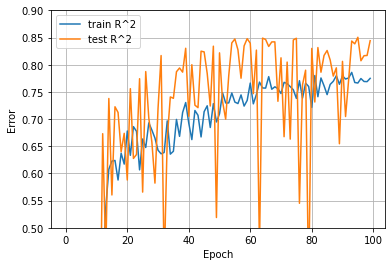

In [67]:
#plot_loss(dnn_history, y_min=0.5, y_max=0.9)
#plt.plot(history)
plot_loss(history, y_min=0.5, y_max=0.9)

In [71]:
result = best_model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 1ms/step - loss: 3119.0137 - mae: 3119.0137 - mean_squared_error: 22272892.0000 - r_square: 0.8565


In [72]:
print(str(result))

[3119.013671875, 3119.013671875, 22272892.0, 0.8565341234207153]


# Random Forest

In [18]:
from sklearn.model_selection import cross_val_score, ShuffleSplit

def cross_validate(model, X_train, y_train, cross_val_test_set_size):
    """
    cross validates a model
    :param model: model to test
    :param X_train: test set (X)
    :param y_train: test set (y)
    :param cross_val_test_set_size: relative size of validation set
    :return: mean and standard deviation for test scores
    """
    cv = ShuffleSplit(n_splits=5, test_size=cross_val_test_set_size, random_state=0)
    scores = cross_val_score(model, X_train, y_train.values.ravel(), cv=cv)
    return scores.mean(), scores.std()

In [15]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(max_depth=4, random_state=0)
mean, std = cross_validate(clf, X_train, y_train, validation_split_size)
print("RANDOM FOREST: %0.5f mean accuracy with a standard deviation of %0.5f" % (mean, std))
clf.fit(X_train, y_train.values.ravel())

RANDOM FOREST: 0.84147 mean accuracy with a standard deviation of 0.01782


RandomForestRegressor(max_depth=4, random_state=0)

In [16]:
clf.score(X_test, y_test.values.ravel())

0.8714346169733819

In [17]:
clf.predict([[0.9, 0, 0, 0.1, 0, 0,0,0,1]])

/home/jstock/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([14183.52296664])

### Hyperparemeter tuning

In [20]:
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest
import numpy as np

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Maximum number of levels in tree
max_depth = [3,4,5,6]
max_features = [0.5,0.6,0.7,0.8,0.9,0.95,1.0]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 300, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 300 candidates, totalling 900 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=300,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 4, 5, 6],
                                        'max_features': [0.5, 0.6, 0.7, 0.8,
                                                         0.9, 0.95, 1.0],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [21]:
print(f'BEST PARAMS: {rf_random.best_params_}')
rfff = RandomForestRegressor(**rf_random.best_params_)

BEST PARAMS: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.7, 'max_depth': 5, 'bootstrap': True}


In [22]:
# train again
mean, std = cross_validate(rfff, X_train, y_train, validation_split_size)
print("RANDOM FOREST: %0.5f mean accuracy with a standard deviation of %0.5f" % (mean, std))
rfff.fit(X_train, y_train.values.ravel())
rfff.score(X_test, y_test.values.ravel())

RANDOM FOREST: 0.84196 mean accuracy with a standard deviation of 0.01963


0.8800714441127572

In [23]:
from sklearn.model_selection import GridSearchCV# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [4,5,6],
    'max_features': [0.65, 0.7, 0.75, 0.8, 0.85, 0.9],
    'min_samples_leaf': [2, 3, 4, 5],
    'min_samples_split': [3,4,5,6,7,8,9,10],
    'n_estimators': [900, 950, 1000, 1050, 1100, 1150]
}# Create a based model
rf = RandomForestRegressor()# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                           cv = 3, n_jobs = -1, verbose = 1)
grid_search.fit(X_train, y_train.values.ravel())
grid_search.best_params_

Fitting 3 folds for each of 3456 candidates, totalling 10368 fits


{'bootstrap': True,
 'max_depth': 4,
 'max_features': 0.8,
 'min_samples_leaf': 5,
 'min_samples_split': 9,
 'n_estimators': 1050}

In [24]:
print(f'BEST PARAMS: {grid_search.best_params_}')
rffff = RandomForestRegressor(**grid_search.best_params_)

BEST PARAMS: {'bootstrap': True, 'max_depth': 4, 'max_features': 0.8, 'min_samples_leaf': 5, 'min_samples_split': 9, 'n_estimators': 1050}


In [25]:
# train again
mean, std = cross_validate(rffff, X_train, y_train, validation_split_size)
print("RANDOM FOREST: %0.5f mean accuracy with a standard deviation of %0.5f" % (mean, std))
rffff.fit(X_train, y_train.values.ravel())
rffff.score(X_test, y_test.values.ravel())

RANDOM FOREST: 0.84350 mean accuracy with a standard deviation of 0.01929


0.8771455163913252

## Random Forest without region attribute (test scenario)

In [9]:
X_train

,age,sex,bmi,children,smoker,region0,region1,region2,region3
560,0.608696,0,0.107345,0.4,0,0,1,0,0
1285,0.630435,0,0.224913,0.0,0,1,0,0,0
1142,0.739130,0,0.239440,0.0,0,0,0,1,0
969,0.456522,0,0.493947,1.0,0,0,0,1,0
486,0.782609,0,0.148238,0.6,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1095,0.000000,0,0.414044,0.8,0,1,0,0,0
1130,0.456522,0,0.212806,1.0,0,0,0,1,0
1294,0.869565,1,0.247915,0.0,0,1,0,0,0
860,0.413043,0,0.851224,0.4,1,0,0,0,1


In [21]:
X_train_no_region = X_train.copy()
X_train_no_region = X_train_no_region.drop(columns=["region0", "region1", "region2", "region3"])

X_test_no_region = X_test.copy()
X_test_no_region = X_test_no_region.drop(columns=["region0", "region1", "region2", "region3"])

In [22]:
from sklearn.ensemble import RandomForestRegressor

rf_no_region = RandomForestRegressor(bootstrap=True, max_depth=4, max_features=0.8, min_samples_leaf=5, min_samples_split=9, n_estimators=1050)

mean, std = cross_validate(rf_no_region, X_train_no_region, y_train, validation_split_size)
print("RANDOM FOREST: %0.5f mean accuracy with a standard deviation of %0.5f" % (mean, std))
rf_no_region.fit(X_train_no_region, y_train.values.ravel())
rf_no_region.score(X_test_no_region, y_test.values.ravel())


RANDOM FOREST: 0.84349 mean accuracy with a standard deviation of 0.01914


0.8774715990241138

## Linear Regression

In [37]:
from sklearn.linear_model import LinearRegression

clf_lr = LinearRegression()
mean, std = cross_validate(clf_lr, X_train, y_train, validation_split_size)
print("LINEAR REGRESSION: %0.5f mean accuracy with a standard deviation of %0.5f" % (mean, std))
clf_lr.fit(X_train, y_train.values.ravel())

LINEAR REGRESSION: 0.72373 mean accuracy with a standard deviation of 0.02820


LinearRegression()

In [38]:
clf_lr.score(X_test, y_test.values.ravel())

0.7836721494853242